In [73]:
import AGG
import pandas as pd

# cluster reads:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# filename = "~/Analysis/AoU/PhysicalPhasingCost.tsv"
# df = pd.read_csv(filename, sep="\t")
# df = df[df.status == "Succeeded"]
# df.cost.mean(),df.shape

In [4]:
filename = "./HPRC/HG00438.ccs.annotated.gfa"
graph = AGG.GraphicalGenome(filename)

In [5]:
# for edge in graph.edges.keys():
#     print(edge, graph.edges[edge].get("variants"))

In [6]:
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Variant:
    pos: int          # Position on reference
    ref_allele: str   # Reference allele
    alt_allele: str   # Alternative allele
    variant_type: str # Type of variant (SNP, INS, DEL)
    allele_count: int # how many reads supporting
    
def get_variant_from_cigar(cigar: str, ref_seq: str, alt_seq: str, ref_start: int, allelecount: int) -> List[Variant]:
    """
    Extract variants from a CIGAR string comparing reference and alternate sequences.
    
    Args:
        cigar: CIGAR string (e.g., "5=1X2=1I3=2D1=")
        ref_seq: Reference sequence
        alt_seq: Alternate sequence
        ref_start: Starting position on reference (default 0)
    
    Returns:
        List of Variant objects
    """
    variants = []
    poscount = {}
    ref_pos = 0
    alt_pos = 0
    
    # Parse CIGAR string into operations
    operations = []
    num = ""
    for c in cigar:
        if c.isdigit():
            num += c
        else:
            operations.append((int(num), c))
            num = ""
    
    # Process each operation
    for length, op in operations:
        if op == '=':  # Match
            ref_pos += length
            alt_pos += length
            for i in range(length):
                pos = ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
        elif op == 'X':  # Mismatch
            for i in range(length):
                pos=ref_start + ref_pos + i
                ref_allele=ref_seq[ref_pos + i]
                alt_allele=alt_seq[alt_pos + i]
                poscount[pos] = poscount.get(pos, 0) + allelecount
                variants.append(Variant(
                    pos,
                    ref_allele,
                    alt_allele,
                    variant_type="SNP",
                    allele_count=allelecount
                ))
            ref_pos += length
            alt_pos += length

        elif op == 'I':  # Insertion
            pos=ref_start + ref_pos
            try:
                ref_allele=ref_seq[ref_pos-1]
            except:
                print(ref_seq, len(ref_seq), ref_pos)
                ref_allele = "-"
            alt_allele=alt_seq[alt_pos-1:alt_pos + length]
            if ref_seq[ref_pos-1] != alt_seq[alt_pos-1]:
                print(ref_seq[ref_pos-1], alt_seq[alt_pos-1], cigar)
            variants.append(Variant(
                pos,
                ref_allele,
                alt_allele,
                variant_type="INS",
                allele_count=allelecount
            ))
            alt_pos += length
            
        elif op == 'D':  # Deletion
            pos=ref_start + ref_pos
            ref_allele=ref_seq[ref_pos-1:ref_pos + length]
            for i in range(length):
                pos = ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
                
            try:
                alt_allele=alt_seq[alt_pos-1]
            except:
                print(alt_seq, len(alt_seq), alt_pos)
                alt_allele = "-"
            if ref_seq[ref_pos-1] != alt_seq[alt_pos-1]:
                print(ref_seq[ref_pos-1], alt_seq[alt_pos-1], cigar)
            variants.append(Variant(
                pos,
                ref_allele,
                alt_allele,
                variant_type="DEL",
                allele_count=allelecount
            ))
            ref_pos += length
            
    return variants, poscount


In [22]:
def findBedge(Graph, src, dst, refstrain, k):
    # revision add first anchor
    paths = AGG.Find_all_Path_between_anchors(Graph, src, dst, {refstrain})
    subpaths = paths.subpath
    
    if len(subpaths) < 1:
        return ""
    for p, strain in subpaths:
        seq = AGG.reconstruct_path_seq(Graph, path = p)
    return seq[:-k] 

def get_variants(graph, k, ref_name, threshold):
    Var = []
    Record = {}
    coverage = {}
    edgelist = sorted(graph.edges.keys())
    for edge in edgelist:
        allele_count = len(graph.edges[edge].get('reads', []))
        readlist = graph.edges[edge]['reads']
        if allele_count <= threshold:
            continue
        cigar = graph.edges[edge].get('variants', "")
        if cigar == "":
            continue

        src = graph.incoming[edge][0]
        dst = graph.outgoing[edge][0]

        if src == "SOURCE" or dst == "SINK":
            continue

        refstart = int(graph.anchor[src]["pos"]) # start from the src anchor
        if dst < src:
            continue
        
        ref_seq = findBedge(graph, src, dst, ref_name, k)
        alt_seq = graph.anchor.get(src, {}).get("seq", "") + graph.edges[edge]['seq']
        variants, poscount = get_variant_from_cigar(cigar, ref_seq, alt_seq, refstart, allele_count) 
        Var += variants
        for pos, count in poscount.items():
            coverage[pos] = coverage.get(pos, 0) + count
        for var in variants:
            key = (var.pos, var.ref_allele, var.alt_allele)
            Record[key] = Record.get(key, []) + readlist

    return Var, Record, coverage

In [23]:
Var, Record, coverage = get_variants(graph, 21, "NC_012920.1", threshold=2)

In [24]:
# Record

In [25]:
# Var_threshold = 0.1
# filtered_var = [v for v in Var if v.allele_count/float(coverage[v.pos]) > Var_threshold]

In [26]:
def find_all_reads(graph):
    read_set = []
    edgelist = sorted(graph.edges.keys())
    for edge in edgelist:
        readlist = graph.edges[edge]['reads']
        read_set += readlist
    read_set = list(set(read_set))
    return read_set

In [27]:
# filtered_var

In [51]:
import pandas as pd
import numpy
read_set = sorted(find_all_reads(graph))
read_set_dict = dict(zip(read_set, range(len(read_set))))
var_record = sorted(set([(v.pos, v.ref_allele, v.alt_allele) for v in Var]))
var_record_dict = dict(zip(var_record, range(len(var_record))))

matrix = numpy.zeros([len(var_record), len(read_set)])

for var in var_record:
    readlist = set(Record.get(var))
    r_index = var_record_dict[var]
    for read in readlist:
        c_index = read_set_dict[read]
        matrix[r_index, c_index] += 1


In [55]:
len(var_record), len(set(var_record)), type(var_record)

(344, 344, list)

In [56]:
# numpy.where(matrix > 1)

In [57]:
# Record.get((5231, 'G', 'GC'))
df = pd.DataFrame(matrix, index=var_record, columns=read_set)
df.shape

(344, 176)

<Axes: ylabel='Count'>

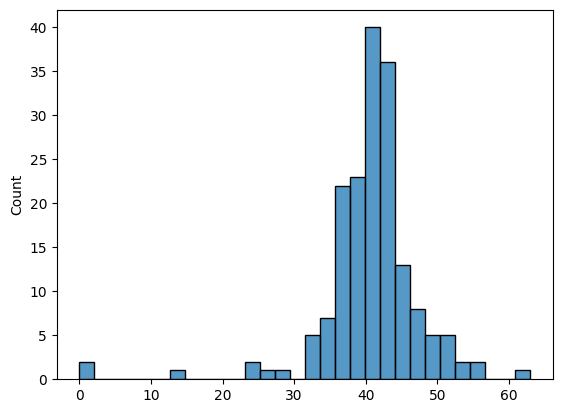

In [59]:
import seaborn as sns
number_of_var = df.sum().values
number_of_read = df.sum(axis=1).values
sns.histplot(number_of_var)

<Axes: ylabel='Count'>

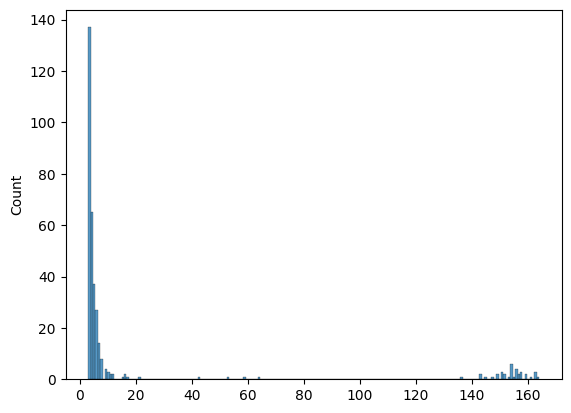

In [60]:
sns.histplot(number_of_read)

In [61]:
def elbow_method(df, max_clusters=15, random_state=42, plot=True):
        """
        Apply the elbow method using the sum of squared distances
        
        Args:
            plot: Whether to plot the results
            
        Returns:
            optimal_k: Optimal number of clusters based on elbow method
        """
        inertia = []
        k_range = range(1, max_clusters + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state= random_state)
            kmeans.fit(df)
            inertia.append(kmeans.inertia_)
        

        # If kneed fails, use simple heuristic
        deltas = np.diff(inertia)
        optimal_k = np.argmax(np.diff(deltas)) + 2
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, inertia, 'o-', linewidth=2, markersize=8)
            plt.xlabel('Number of Clusters (k)', fontsize=14)
            plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=14)
            plt.title('Elbow Method for Optimal k', fontsize=16)
            
            if optimal_k:
                plt.axvline(x=optimal_k, color='r', linestyle='--', 
                           label=f'Optimal k = {optimal_k}')
                plt.legend(fontsize=12)
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        print(f"Optimal number of clusters (Elbow Method): {optimal_k}")
        return optimal_k

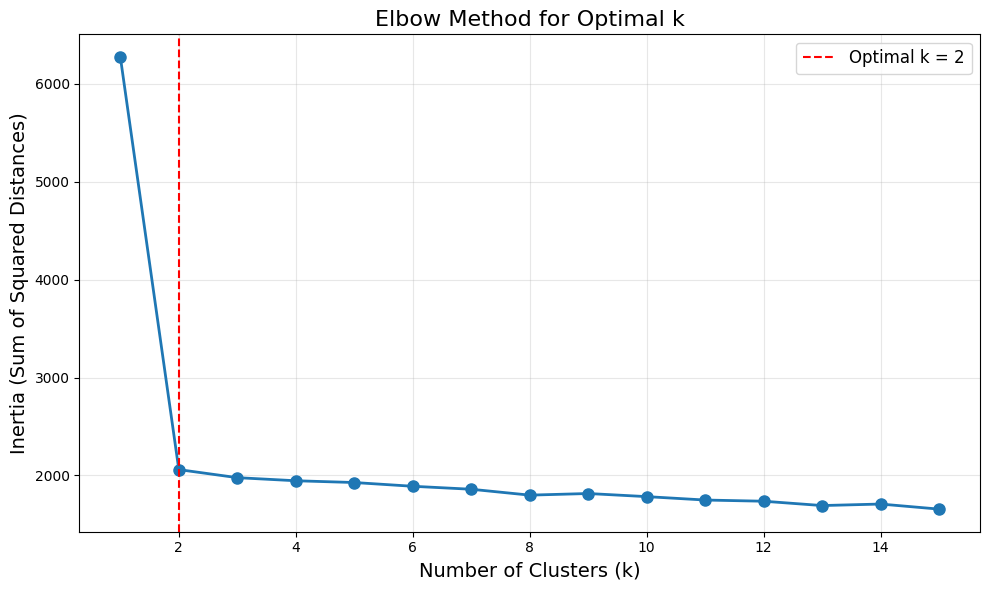

Optimal number of clusters (Elbow Method): 2


2

In [62]:
elbow_method(df, max_clusters=15, random_state=42, plot=True)

In [74]:

def hierarchical_clustering_analysis(df, max_clusters=15, plot=True, labels = None):
        """
        Analyze hierarchical clustering dendrogram
        
        Args:
            plot: Whether to plot the dendrogram
            
        Returns:
            suggested_k: Suggested number of clusters based on dendrogram
        """
        # Compute linkage matrix
        Z = linkage(df, method='ward')
        
        if plot:
            plt.figure(figsize=(12, 8))
            dendro = dendrogram(
                Z,
                truncate_mode='lastp',  # Show only the last p merged clusters
                p=max_clusters,
                leaf_rotation=90.,
                leaf_font_size=12.,
                show_contracted=True,
                labels=labels
            )
            # map vars to branches

            # plt.xticks(range(1, len(df) + 1), df.columns)
            plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
            plt.xlabel('Sample index or (cluster size)', fontsize=14)
            plt.ylabel('Distance', fontsize=14)
            plt.axhline(y=np.median(Z[-max_clusters:, 2]), color='r', linestyle='--')
            plt.tight_layout()
            plt.show()
        
        # Find where the largest vertical distance is
        last_distances = Z[-max_clusters:, 2]
        median_distance = np.median(last_distances)
        clusters = fcluster(Z, median_distance, criterion='distance')
        suggested_k = len(np.unique(clusters))
        # acceleration = np.diff(last_distances, 2)
        # if len(acceleration) > 0:
        #     suggested_k = max_clusters - np.argmax(acceleration) - 1
        # else:
        #     suggested_k = 2  # Default if not enough clusters
        
        print(f"Suggested number of clusters (Dendrogram Analysis): {suggested_k}")
        return suggested_k, clusters

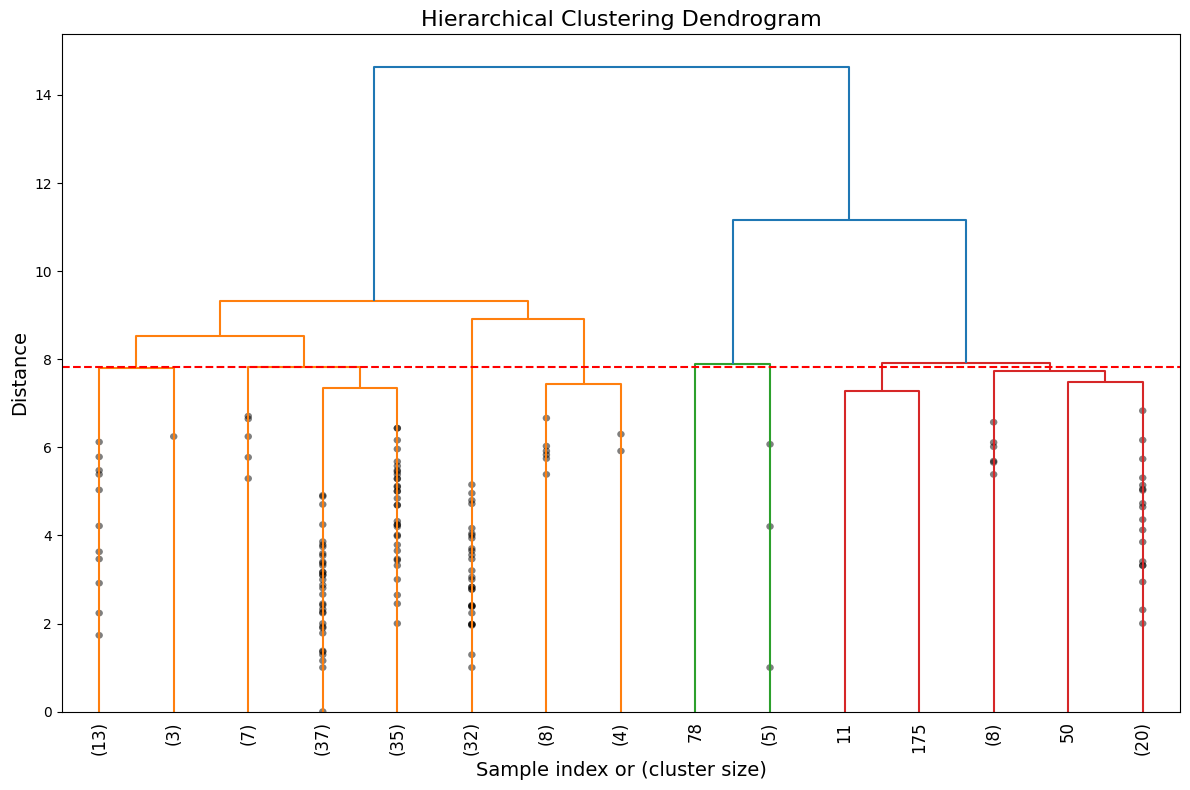

Suggested number of clusters (Dendrogram Analysis): 8


(8,
 array([5, 2, 2, 3, 4, 2, 1, 3, 2, 5, 2, 7, 3, 3, 4, 2, 2, 3, 2, 3, 4, 8,
        2, 2, 3, 2, 2, 2, 4, 3, 2, 1, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2,
        3, 3, 2, 8, 2, 3, 8, 3, 2, 2, 2, 1, 5, 2, 2, 3, 8, 2, 2, 1, 3, 3,
        8, 3, 8, 2, 2, 3, 1, 2, 2, 8, 3, 8, 6, 8, 1, 8, 2, 2, 3, 3, 2, 8,
        8, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 8, 2, 8, 2, 2, 2, 4, 2, 8,
        2, 8, 3, 1, 1, 8, 5, 4, 4, 8, 4, 2, 2, 2, 2, 3, 1, 2, 4, 3, 2, 2,
        2, 2, 2, 8, 3, 8, 2, 8, 5, 3, 1, 3, 2, 2, 8, 8, 8, 1, 2, 4, 8, 1,
        4, 1, 3, 2, 8, 4, 3, 2, 8, 8, 1, 3, 3, 3, 2, 1, 2, 2, 2, 2, 2, 7],
       dtype=int32))

In [75]:
hierarchical_clustering_analysis(df.T)

In [91]:
# SCITE
df.astype(int).to_csv("./SCITE/mutation_input.csv", sep = " ", header = None, index = None)
df.shape


(344, 176)

Creating phylogenetic tree using Biopython with nj method
Input matrix shape: (344, 176)
Phylogeny will be built from 176 samples with 344 mutations
Tree constructed successfully
Tree has 350 nodes and 176 terminals
Simplified tree from 174 to 20 branches
Branch lengths - Min: 0, Max: 0.5548252176133313
Saved figure to example_biopython_phylogeny_tree.png


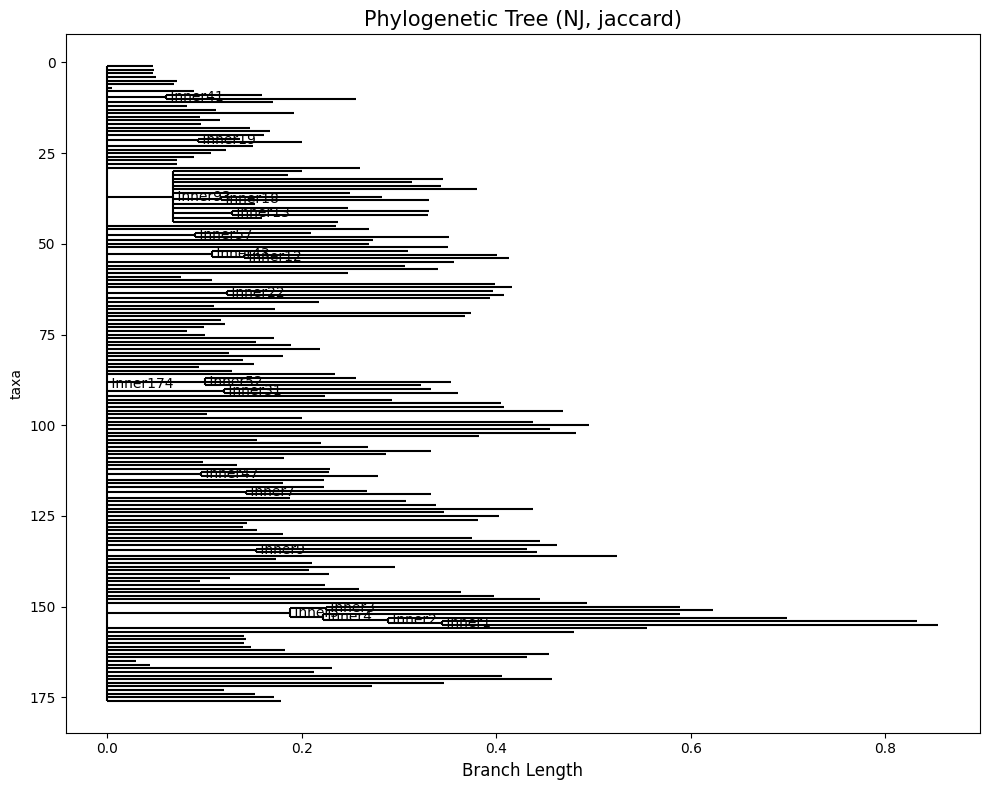

Tree visualization saved to example_biopython_phylogeny_tree.png

Branch annotations (defining mutations):
Branch leading to m64043_200713_062240/108792222/ccs: (72, 'A', 'G'), (247, 'GA', 'G'), (262, 'A', 'G'), (309, 'C', 'CCCCT'), (309, 'T', 'C')...
Branch leading to m64043_200710_174426/125569156/ccs: (72, 'A', 'G'), (247, 'GA', 'G'), (262, 'A', 'G'), (309, 'C', 'CCCCT'), (309, 'T', 'C')...
Branch leading to m64043_200710_174426/5702750/ccs: (65, 'T', 'TG'), (72, 'A', 'G'), (247, 'GA', 'G'), (262, 'A', 'G'), (309, 'C', 'CCCCT')...
Branch leading to m64043_200714_124814/180289853/ccs: (72, 'A', 'G'), (247, 'GA', 'G'), (262, 'A', 'G'), (309, 'C', 'CCCCT'), (309, 'T', 'C')...
Branch leading to m64043_200714_124814/180289853/ccs: (4057, 'T', 'TC')
Branch leading to m64043_200714_124814/180289853/ccs: (514, 'GCA', 'G'), (3428, 'G', 'GC'), (8939, 'TC', 'T')
Branch leading to m64043_200714_124814/176751142/ccs: (3565, 'A', 'AC'), (5743, 'CG', 'C'), (6185, 'T', 'TC')
Branch leading to m6404

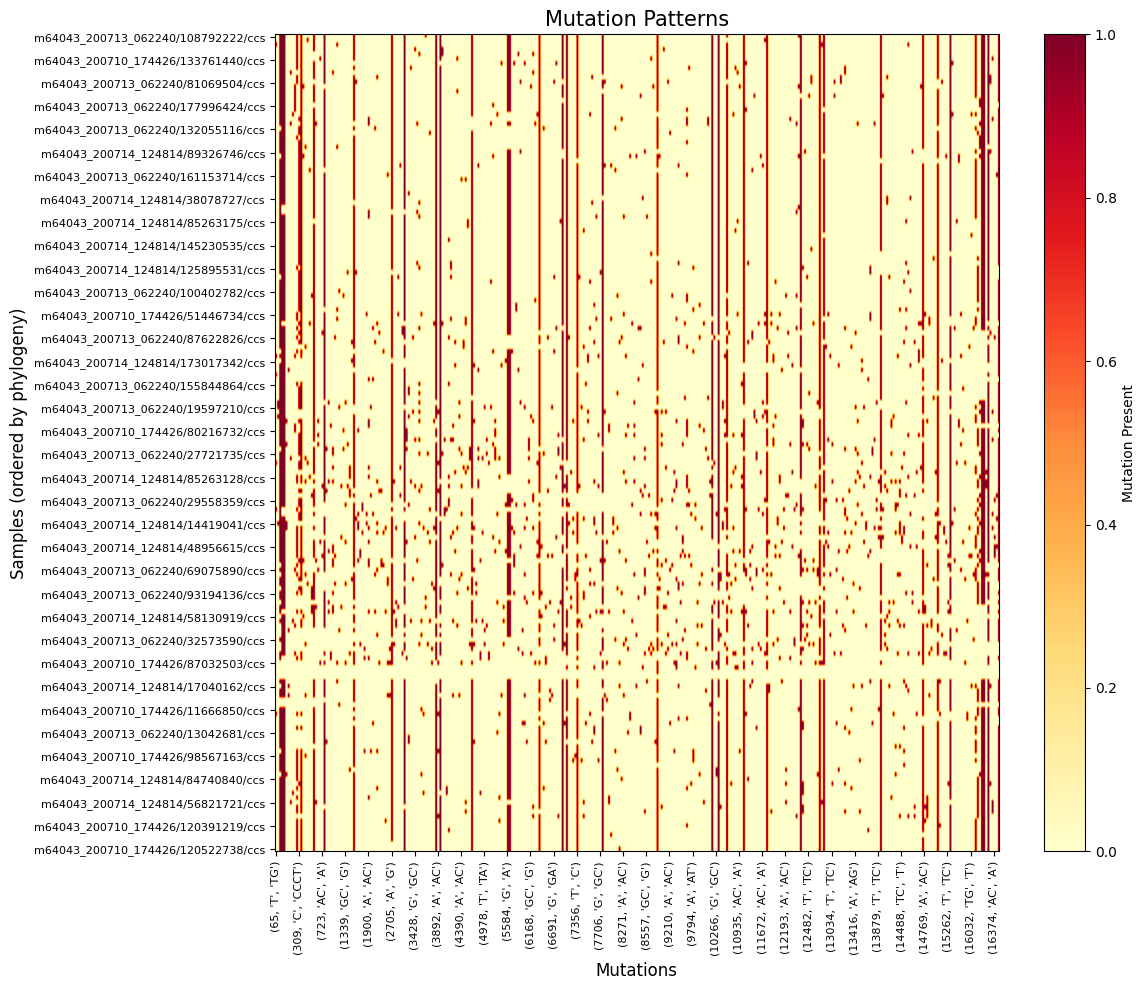

Mutation heatmap saved to example_biopython_phylogeny_heatmap.png
Tree saved in Newick format to example_biopython_phylogeny.newick


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import tempfile
import io
import os

class BioPythonPhylogeny:
    """
    Construct phylogenetic trees from binary mutation matrices using Biopython
    """
    
    def __init__(self, mutation_df, method='nj', distance_metric='jaccard'):
        """
        Initialize the phylogeny builder
        
        Parameters:
        -----------
        mutation_df : pandas DataFrame
            Binary mutation matrix with variants as rows, samples as columns
        method : str
            Tree construction method: 'nj' (Neighbor-Joining) or 'upgma'
        distance_metric : str
            Distance metric: 'identity', 'jaccard', 'hamming'
        """
        self.mutation_df = mutation_df
        self.method = method
        self.distance_metric = distance_metric
        self.tree = None
        
        # Check if matrix needs to be transposed
        # For phylogenetic trees, we want samples as rows and mutations as columns

        self.data_matrix = mutation_df.T
        self.samples = mutation_df.columns
        self.mutations = mutation_df.index
            
        print(f"Phylogeny will be built from {len(self.samples)} samples with {len(self.mutations)} mutations")
    
    def create_alignment(self):
        """
        Convert binary matrix to a Biopython MultipleSeqAlignment
        
        Returns:
        --------
        alignment : Bio.Align.MultipleSeqAlignment
            Alignment object for tree construction
        """
        # Create a list to hold the sequence records
        records = []
        
        # Convert each row (sample) to a sequence record
        for sample_name in self.data_matrix.index:
            # Convert binary data to sequence string
            seq_data = ''.join(self.data_matrix.loc[sample_name].astype(str))
            
            # Create a SeqRecord
            record = SeqRecord(
                Seq(seq_data),
                id=str(sample_name),
                name=str(sample_name),
                description=""
            )
            
            records.append(record)
        
        # Create alignment
        alignment = MultipleSeqAlignment(records)
        
        return alignment
    
    def calculate_distance_matrix(self):
        """
        Calculate distance matrix from binary data
        
        Returns:
        --------
        dm : Bio.Phylo.TreeConstruction._DistanceMatrix
            Distance matrix for tree construction
        """
        # Create alignment first
        alignment = self.create_alignment()
        
        # If using the built-in calculator
        if self.distance_metric in ['identity', 'blastn', 'trans']:
            calculator = DistanceCalculator(self.distance_metric)
            dm = calculator.get_distance(alignment)
            return dm
        
        # For custom distance metrics (jaccard, hamming)
        sample_names = [str(name) for name in self.data_matrix.index]
        matrix = []
        
        # Calculate distances between all pairs of samples
        for i in range(len(sample_names)):
            row = []
            for j in range(i + 1):
                if i == j:
                    row.append(0)
                else:
                    sample1 = self.data_matrix.iloc[i].values
                    sample2 = self.data_matrix.iloc[j].values
                    
                    if self.distance_metric == 'jaccard':
                        # Jaccard distance
                        intersection = np.sum(np.logical_and(sample1, sample2))
                        union = np.sum(np.logical_or(sample1, sample2))
                        distance = 1 - (intersection / union if union > 0 else 0)
                    elif self.distance_metric == 'hamming':
                        # Hamming distance (proportion of positions that differ)
                        distance = np.mean(sample1 != sample2)
                    else:
                        raise ValueError(f"Unsupported distance metric: {self.distance_metric}")
                    
                    row.append(distance)
            
            matrix.append(row)
        
        # Create the distance matrix
        dm = _DistanceMatrix(sample_names, matrix)
        
        return dm
    
    def build_tree(self):
        """
        Build phylogenetic tree from distance matrix
        
        Returns:
        --------
        tree : Bio.Phylo.BaseTree
            Phylogenetic tree
        """
        # Calculate distance matrix
        dm = self.calculate_distance_matrix()
        
        # Create tree constructor
        constructor = DistanceTreeConstructor()
        
        # Build tree with selected method
        if self.method == 'nj':
            tree = constructor.nj(dm)
        elif self.method == 'upgma':
            tree = constructor.upgma(dm)
        else:
            raise ValueError(f"Unsupported tree construction method: {self.method}")
        
        self.tree = tree
        return tree
    
    def plot_tree(self, output_file=None, show=True, fig_size=(10, 8), show_leaf_names=False, max_branches=None):
        """Plot phylogenetic tree with debugging"""
        if self.tree is None:
            self.build_tree()
        
        # Check if tree is empty or invalid
        if len(list(self.tree.find_clades())) <= 1:
            print("ERROR: Tree contains no branches. Check your distance matrix for invalid values.")
            return None
            
        # Debug: Print tree structure
        print(f"Tree has {len(list(self.tree.find_clades()))} nodes and {len(self.tree.get_terminals())} terminals")
        
        # Make a copy of the tree to avoid modifying the original
        import copy
        tree_copy = copy.deepcopy(self.tree)
        
        # If max_branches is specified, collapse branches to meet the limit
        if max_branches is not None:
            self._simplify_tree(tree_copy, max_branches)
    
        # If hiding leaf names, store original names and set display names to empty
        if not show_leaf_names:
            for leaf in tree_copy.get_terminals():
                leaf.original_name = leaf.name
                leaf.name = ""
        
        # Create figure with explicit axes limits
        fig, ax = plt.subplots(figsize=fig_size)
        
        # Debug: Check if any branches have length
        branch_lengths = [clade.branch_length for clade in tree_copy.find_clades() 
                        if clade.branch_length is not None]
        if branch_lengths:
            print(f"Branch lengths - Min: {min(branch_lengths)}, Max: {max(branch_lengths)}")
        else:
            print("ERROR: No branch lengths found in tree")
        
        try:
            # Draw the tree with explicit parameters
            Phylo.draw(tree_copy, axes=ax, do_show=False)
            
            # Ensure the axes have content
            ax.set_title(f'Phylogenetic Tree ({self.method.upper()}, {self.distance_metric})', fontsize=15)
            ax.set_xlabel('Branch Length', fontsize=12)
            
            # Force the axes to auto-scale
            ax.autoscale()
            plt.tight_layout()
            
            # Save if output file is specified
            if output_file:
                plt.savefig(output_file, dpi=300, bbox_inches='tight')
                print(f"Saved figure to {output_file}")
            
            # Show the plot if requested
            if show:
                plt.show()
            
            return fig
        except Exception as e:
            print(f"ERROR during tree plotting: {str(e)}")
            return None
        
    def annotate_tree_with_mutations(self):
        """
        Annotate tree branches with mutations that define each clade
        
        Returns:
        --------
        annotations : dict
            Dictionary mapping clades to defining mutations
        """
        if self.tree is None:
            self.build_tree()
        
        # Create a dictionary to store mutations for each clade
        clade_mutations = {}
        
        # Function to recursively process clades
        def process_clade(clade, parent_profile=None):
            # Get all samples in this clade
            samples = []
            for leaf in clade.get_terminals():
                samples.append(leaf.name)
            
            if not samples:
                return
            
            # Calculate mutation profile for this clade (common mutations)
            clade_profile = np.ones(len(self.mutations))
            for sample in samples:
                if sample in self.data_matrix.index:
                    sample_profile = self.data_matrix.loc[sample].values
                    clade_profile = np.logical_and(clade_profile, sample_profile)
            
            # Find mutations unique to this clade (not in parent)
            if parent_profile is not None:
                unique_mutations = np.logical_and(clade_profile, np.logical_not(parent_profile))
                defining_mutations = [self.mutations[i] for i in range(len(self.mutations)) 
                                     if unique_mutations[i]]
                
                # Store defining mutations
                if len(defining_mutations) > 0:
                    clade_mutations[clade] = defining_mutations
            
            # Process child clades
            for child in clade.clades:
                process_clade(child, clade_profile)
        
        # Start from the root
        process_clade(self.tree.root)
        
        # Print annotations
        print("\nBranch annotations (defining mutations):")
        for clade, mutations in clade_mutations.items():
            # Get clade name (first leaf for identification)
            leaves = [leaf.name for leaf in clade.get_terminals()]
            if leaves:
                print(f"Branch leading to {leaves[0]}: {', '.join(str(m) for m in mutations[:5])}" + 
                     ("..." if len(mutations) > 5 else ""))
        
        return clade_mutations
    
    def export_newick(self, output_file=None):
        """
        Export tree in Newick format
        
        Parameters:
        -----------
        output_file : str
            Path to save the Newick file
            
        Returns:
        --------
        newick : str
            Tree in Newick format
        """
        if self.tree is None:
            self.build_tree()
        
        # Create a string buffer to hold the Newick format
        handle = io.StringIO()
        Phylo.write(self.tree, handle, 'newick')
        
        # Get the Newick string
        newick = handle.getvalue()
        
        # Save to file if specified
        if output_file:
            with open(output_file, 'w') as f:
                f.write(newick)
        
        return newick
    
    def plot_mutation_heatmap(self, output_file=None, show=True, fig_size=(12, 10)):
        """
        Plot mutation heatmap with samples ordered according to the tree
        
        Parameters:
        -----------
        output_file : str
            Path to save the heatmap image
        show : bool
            Whether to display the heatmap
        fig_size : tuple
            Figure size (width, height)
            
        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure with the heatmap
        """
        if self.tree is None:
            self.build_tree()
        
        # Get sample order from tree leaves
        leaf_names = [leaf.name for leaf in self.tree.get_terminals()]
        
        # Reorder data matrix based on tree
        ordered_matrix = self.data_matrix.loc[leaf_names]
        
        # Create figure
        fig, ax = plt.subplots(figsize=fig_size)
        
        # Create heatmap
        im = ax.imshow(ordered_matrix, cmap='YlOrRd', aspect='auto')
        
        # Customize the plot
        ax.set_title('Mutation Patterns', fontsize=15)
        ax.set_xlabel('Mutations', fontsize=12)
        ax.set_ylabel('Samples (ordered by phylogeny)', fontsize=12)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Mutation Present', fontsize=10)
        
        # Set tick labels (limit number to avoid crowding)
        max_labels = 30
        if len(leaf_names) > max_labels:
            step = len(leaf_names) // max_labels
            ax.set_yticks(range(0, len(leaf_names), step))
            ax.set_yticklabels(leaf_names[::step], fontsize=8)
        else:
            ax.set_yticks(range(len(leaf_names)))
            ax.set_yticklabels(leaf_names, fontsize=8)
        
        if len(self.mutations) > max_labels:
            step = len(self.mutations) // max_labels
            ax.set_xticks(range(0, len(self.mutations), step))
            ax.set_xticklabels([str(m) for m in self.mutations[::step]], fontsize=8, rotation=90)
        else:
            ax.set_xticks(range(len(self.mutations)))
            ax.set_xticklabels([str(m) for m in self.mutations], fontsize=8, rotation=90)
        
        plt.tight_layout()
        
        # Save if output file is specified
        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
        
        # Show the plot if requested
        if show:
            plt.show()
        
        return fig

    def _simplify_tree(self, tree, max_branches):
        """
        Simplify tree by collapsing branches to meet maximum branch limit
        
        Parameters:
        -----------
        tree : Bio.Phylo.BaseTree
            Tree to simplify
        max_branches : int
            Maximum number of branches to keep
        """
        # Count total branches (internal nodes)
        total_branches = sum(1 for clade in tree.find_clades() if not clade.is_terminal())
        
        if total_branches <= max_branches:
            return  # No simplification needed
            
        # Calculate how many branches to collapse
        to_collapse = total_branches - max_branches
        
        # Strategy: Collapse branches with smallest branch lengths first
        branches = [(clade, clade.branch_length) for clade in tree.find_clades() 
                    if not clade.is_terminal() and len(clade.clades) > 0]
        
        # Sort by branch length (shortest first)
        branches.sort(key=lambda x: x[1] if x[1] is not None else float('inf'))
        
        # Collapse branches
        collapsed = 0
        for clade, _ in branches:
            if collapsed >= to_collapse:
                break
                
            # Skip the root node
            if clade == tree.root:
                continue
                
            # Collapse this branch by moving its children up one level
            parent = tree.root
            for node in tree.find_clades():
                if clade in node.clades:
                    parent = node
                    break
            
            # Remove this clade from parent
            parent.clades.remove(clade)
            
            # Add its children to parent
            for child in clade.clades:
                # Adjust branch length if both have lengths
                if child.branch_length is not None and clade.branch_length is not None:
                    child.branch_length += clade.branch_length
                parent.clades.append(child)
            
            collapsed += 1
        
        print(f"Simplified tree from {total_branches} to {total_branches - collapsed} branches")

# ... existing code ...


def create_phylogeny_from_binary_matrix(df, method='nj', distance_metric='jaccard', 
                                        output_prefix="biopython_phylogeny", max_branches=None):
    """
    Create a phylogenetic tree from a binary mutation matrix using Biopython
    
    Parameters:
    -----------
    df : pandas DataFrame
        Binary mutation matrix (variants as rows, samples as columns)
    method : str
        Tree construction method: 'nj' or 'upgma'
    distance_metric : str
        Distance metric: 'identity', 'jaccard', 'hamming'
    output_prefix : str
        Prefix for output files
        
    Returns:
    --------
    phylogeny : BioPythonPhylogeny
        The phylogeny object with the constructed tree
    """
    print(f"Creating phylogenetic tree using Biopython with {method} method")
    print(f"Input matrix shape: {df.shape}")
    
    # Initialize the phylogeny object
    phylogeny = BioPythonPhylogeny(df, method=method, distance_metric=distance_metric)
    
    # Build the tree
    tree = phylogeny.build_tree()
    print("Tree constructed successfully")
    
    # Plot the tree
    phylogeny.plot_tree(output_file=f"{output_prefix}_tree.png", 
                        max_branches = max_branches)
    print(f"Tree visualization saved to {output_prefix}_tree.png")
    
    # Annotate tree with mutations
    annotations = phylogeny.annotate_tree_with_mutations()
    
    # Plot mutation heatmap
    phylogeny.plot_mutation_heatmap(output_file=f"{output_prefix}_heatmap.png")
    print(f"Mutation heatmap saved to {output_prefix}_heatmap.png")
    
    # Export in Newick format
    newick = phylogeny.export_newick(output_file=f"{output_prefix}.newick")
    print(f"Tree saved in Newick format to {output_prefix}.newick")
    
    return phylogeny




# Create phylogeny
phylogeny = create_phylogeny_from_binary_matrix(
    df,
    method='nj',  # 'nj' for Neighbor-Joining, 'upgma' for UPGMA
    distance_metric='jaccard',  # 'jaccard', 'hamming', or 'identity'
    output_prefix="example_biopython_phylogeny",
    max_branches = 20
)

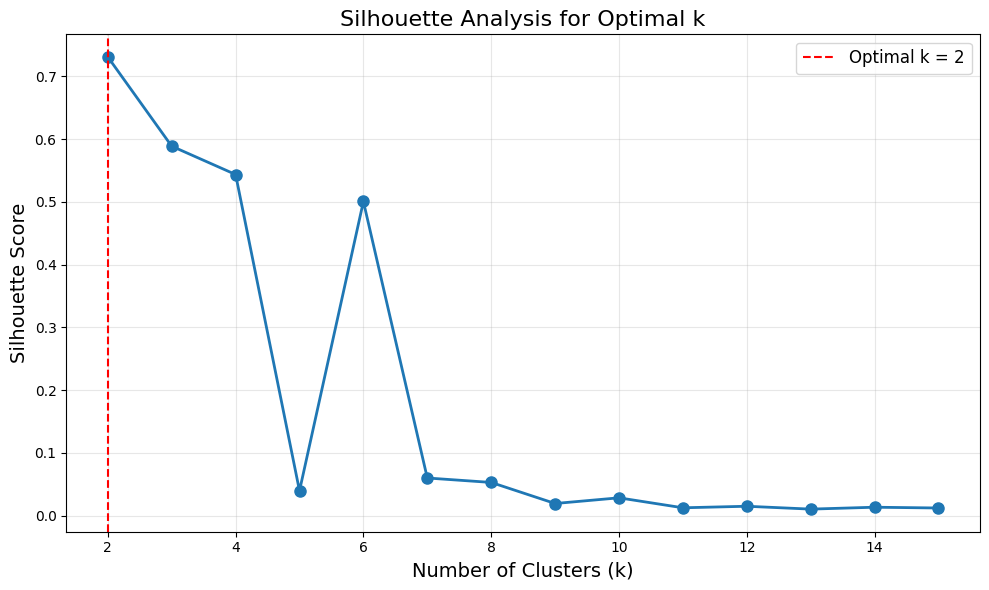

Optimal number of clusters (Silhouette Analysis): 2


2

In [79]:
def silhouette_analysis(df, max_clusters = 15, random_state = 42, plot=True):
        """
        Apply silhouette analysis to find optimal number of clusters
        
        Args:
            plot: Whether to plot the results
            
        Returns:
            optimal_k: Optimal number of clusters based on silhouette analysis
        """
        silhouette_scores = []
        k_range = range(2, max_clusters + 1)  # Silhouette requires at least 2 clusters
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=random_state)
            labels = kmeans.fit_predict(df)
            score = silhouette_score(df, labels)
            silhouette_scores.append(score)
        
        # Find optimal k (highest silhouette score)
        optimal_k = k_range[np.argmax(silhouette_scores)]
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
            plt.xlabel('Number of Clusters (k)', fontsize=14)
            plt.ylabel('Silhouette Score', fontsize=14)
            plt.title('Silhouette Analysis for Optimal k', fontsize=16)
            
            plt.axvline(x=optimal_k, color='r', linestyle='--', 
                       label=f'Optimal k = {optimal_k}')
            plt.legend(fontsize=12)
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        print(f"Optimal number of clusters (Silhouette Analysis): {optimal_k}")
        return optimal_k
    

silhouette_analysis(df=df, max_clusters=15, random_state=42, plot=True)

In [70]:


class ClusterAnalyzer:
    """Class for finding optimal number of clusters in a dataset"""
    
    def __init__(self, data, max_clusters=15, random_state=42):
        """
        Initialize the cluster analyzer
        
        Args:
            data: DataFrame or numpy array with features
            max_clusters: Maximum number of clusters to consider
            random_state: Random seed for reproducibility
        """
        self.data = data
        self.max_clusters = max_clusters
        self.random_state = random_state
        self.scaled_data = None
        
        # Scale the data
        self._preprocess_data()
    
    def _preprocess_data(self):
        """Preprocess and scale the data"""
        # Convert to numpy array if DataFrame
        if isinstance(self.data, pd.DataFrame):
            self.data_array = self.data.values
        else:
            self.data_array = self.data
        
        # Scale the data
        scaler = StandardScaler()
        self.scaled_data = scaler.fit_transform(self.data_array)
        
        # Optional: Apply PCA for visualization if dimensions > 2
        if self.scaled_data.shape[1] > 2:
            self.pca = PCA(n_components=2)
            self.pca_data = self.pca.fit_transform(self.scaled_data)
            print(f"Explained variance with 2 PCA components: {sum(self.pca.explained_variance_ratio_):.2f}")
        else:
            self.pca_data = self.scaled_data
    
    
    
    def silhouette_analysis(self, plot=True):
        """
        Apply silhouette analysis to find optimal number of clusters
        
        Args:
            plot: Whether to plot the results
            
        Returns:
            optimal_k: Optimal number of clusters based on silhouette analysis
        """
        silhouette_scores = []
        k_range = range(2, self.max_clusters + 1)  # Silhouette requires at least 2 clusters
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            labels = kmeans.fit_predict(self.scaled_data)
            score = silhouette_score(self.scaled_data, labels)
            silhouette_scores.append(score)
        
        # Find optimal k (highest silhouette score)
        optimal_k = k_range[np.argmax(silhouette_scores)]
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
            plt.xlabel('Number of Clusters (k)', fontsize=14)
            plt.ylabel('Silhouette Score', fontsize=14)
            plt.title('Silhouette Analysis for Optimal k', fontsize=16)
            
            plt.axvline(x=optimal_k, color='r', linestyle='--', 
                       label=f'Optimal k = {optimal_k}')
            plt.legend(fontsize=12)
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        print(f"Optimal number of clusters (Silhouette Analysis): {optimal_k}")
        return optimal_k
    
    def gap_statistic(self, n_refs=5, plot=True):
        """
        Apply the gap statistic method
        
        Args:
            n_refs: Number of reference datasets to generate
            plot: Whether to plot the results
            
        Returns:
            optimal_k: Optimal number of clusters based on gap statistic
        """
        # Calculate gaps
        gaps = []
        std_devs = []
        k_range = range(1, self.max_clusters + 1)
        
        for k in k_range:
            # Reference inertia (random data)
            ref_inertias = []
            for i in range(n_refs):
                # Generate random data of same shape
                random_data = np.random.random_sample(size=self.scaled_data.shape)
                kmeans = KMeans(n_clusters=k, random_state=self.random_state)
                kmeans.fit(random_data)
                ref_inertias.append(np.log(kmeans.inertia_))
            
            # Actual data inertia
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(self.scaled_data)
            actual_inertia = np.log(kmeans.inertia_)
            
            # Calculate gap
            gap = np.mean(ref_inertias) - actual_inertia
            std_dev = np.std(ref_inertias) * np.sqrt(1 + 1/n_refs)
            
            gaps.append(gap)
            std_devs.append(std_dev)
        
        # Find optimal k (first k where gap[k] ≥ gap[k+1] - std_dev[k+1])
        optimal_k = 1  # Default if no better option found
        for k in range(len(gaps)-1):
            if gaps[k] >= gaps[k+1] - std_devs[k+1]:
                optimal_k = k + 1
                break
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.errorbar(k_range, gaps, yerr=std_devs, fmt='o-', linewidth=2, 
                        capsize=5, markersize=8)
            plt.xlabel('Number of Clusters (k)', fontsize=14)
            plt.ylabel('Gap Statistic', fontsize=14)
            plt.title('Gap Statistic Analysis for Optimal k', fontsize=16)
            
            plt.axvline(x=optimal_k, color='r', linestyle='--', 
                       label=f'Optimal k = {optimal_k}')
            plt.legend(fontsize=12)
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        print(f"Optimal number of clusters (Gap Statistic): {optimal_k}")
        return optimal_k
    
    def calinski_harabasz_analysis(self, plot=True):
        """
        Apply Calinski-Harabasz Index (Variance Ratio Criterion)
        
        Args:
            plot: Whether to plot the results
            
        Returns:
            optimal_k: Optimal number of clusters based on CH index
        """
        ch_scores = []
        k_range = range(2, self.max_clusters + 1)  # CH Index requires at least 2 clusters
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            labels = kmeans.fit_predict(self.scaled_data)
            score = calinski_harabasz_score(self.scaled_data, labels)
            ch_scores.append(score)
        
        # Find optimal k (highest CH score)
        optimal_k = k_range[np.argmax(ch_scores)]
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, ch_scores, 'o-', linewidth=2, markersize=8)
            plt.xlabel('Number of Clusters (k)', fontsize=14)
            plt.ylabel('Calinski-Harabasz Index', fontsize=14)
            plt.title('Calinski-Harabasz Analysis for Optimal k', fontsize=16)
            
            plt.axvline(x=optimal_k, color='r', linestyle='--', 
                       label=f'Optimal k = {optimal_k}')
            plt.legend(fontsize=12)
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        print(f"Optimal number of clusters (Calinski-Harabasz Index): {optimal_k}")
        return optimal_k
    
    def davies_bouldin_analysis(self, plot=True):
        """
        Apply Davies-Bouldin Index
        
        Args:
            plot: Whether to plot the results
            
        Returns:
            optimal_k: Optimal number of clusters based on DB index
        """
        db_scores = []
        k_range = range(2, self.max_clusters + 1)  # DB Index requires at least 2 clusters
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            labels = kmeans.fit_predict(self.scaled_data)
            score = davies_bouldin_score(self.scaled_data, labels)
            db_scores.append(score)
        
        # Find optimal k (lowest DB score)
        optimal_k = k_range[np.argmin(db_scores)]
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, db_scores, 'o-', linewidth=2, markersize=8)
            plt.xlabel('Number of Clusters (k)', fontsize=14)
            plt.ylabel('Davies-Bouldin Index', fontsize=14)
            plt.title('Davies-Bouldin Analysis for Optimal k', fontsize=16)
            
            plt.axvline(x=optimal_k, color='r', linestyle='--', 
                       label=f'Optimal k = {optimal_k}')
            plt.legend(fontsize=12)
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        print(f"Optimal number of clusters (Davies-Bouldin Index): {optimal_k}")
        return optimal_k
    
    def hierarchical_clustering_analysis(self, plot=True):
        """
        Analyze hierarchical clustering dendrogram
        
        Args:
            plot: Whether to plot the dendrogram
            
        Returns:
            suggested_k: Suggested number of clusters based on dendrogram
        """
        # Compute linkage matrix
        Z = linkage(self.scaled_data, method='ward')
        
        if plot:
            plt.figure(figsize=(12, 8))
            dendrogram(
                Z,
                truncate_mode='lastp',  # Show only the last p merged clusters
                p=self.max_clusters,
                leaf_rotation=90.,
                leaf_font_size=12.,
                show_contracted=True,
            )
            plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
            plt.xlabel('Sample index or (cluster size)', fontsize=14)
            plt.ylabel('Distance', fontsize=14)
            plt.axhline(y=np.median(Z[-self.max_clusters:, 2]), color='r', linestyle='--')
            plt.tight_layout()
            plt.show()
        
        # Find where the largest vertical distance is
        last_distances = Z[-self.max_clusters:, 2]
        acceleration = np.diff(last_distances, 2)
        if len(acceleration) > 0:
            suggested_k = self.max_clusters - np.argmax(acceleration) - 1
        else:
            suggested_k = 2  # Default if not enough clusters
        
        print(f"Suggested number of clusters (Dendrogram Analysis): {suggested_k}")
        return suggested_k
    
    def dbscan_epsilon_analysis(self, n_neighbors=5, plot=True):
        """
        Find optimal epsilon parameter for DBSCAN
        
        Args:
            n_neighbors: Number of neighbors for k-distance graph
            plot: Whether to plot the results
            
        Returns:
            epsilon: Optimal epsilon value for DBSCAN
        """
        # Calculate distances to the nth nearest neighbor
        nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(self.scaled_data)
        distances, indices = nbrs.kneighbors(self.scaled_data)
        
        # Sort distances to nth neighbor
        distances = np.sort(distances[:, n_neighbors-1])
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(distances)), distances, 'o-', linewidth=1, markersize=4)
            plt.xlabel('Points (sorted by distance)', fontsize=14)
            plt.ylabel(f'Distance to {n_neighbors}th nearest neighbor', fontsize=14)
            plt.title('K-Distance Graph for DBSCAN Parameter Selection', fontsize=16)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # Find the elbow on the k-distance graph
        try:
            kl = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
            elbow_idx = kl.elbow
            if elbow_idx:
                epsilon = distances[elbow_idx]
                plt.axvline(x=elbow_idx, color='r', linestyle='--', 
                           label=f'Elbow at ε ≈ {epsilon:.3f}')
                plt.legend(fontsize=12)
            else:
                # Use a heuristic if no elbow is found
                epsilon = np.mean(distances)
        except:
            # Use a heuristic if KneeLocator fails
            epsilon = np.mean(distances)
        
        print(f"Suggested epsilon for DBSCAN: {epsilon:.3f}")
        
        # Try DBSCAN with the suggested epsilon
        dbscan = DBSCAN(eps=epsilon, min_samples=n_neighbors)
        labels = dbscan.fit_predict(self.scaled_data)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        print(f"Number of clusters identified by DBSCAN: {n_clusters}")
        print(f"Percentage of outliers: {np.sum(labels == -1) / len(labels):.2%}")
        
        return epsilon, n_clusters
    
    def visualize_clusters(self, n_clusters, method='kmeans'):
        """
        Visualize clusters on a scatter plot (2D representation)
        
        Args:
            n_clusters: Number of clusters to visualize
            method: Clustering method ('kmeans' or 'hierarchical')
        """
        if method == 'kmeans':
            model = KMeans(n_clusters=n_clusters, random_state=self.random_state)
        else:
            model = AgglomerativeClustering(n_clusters=n_clusters)
        
        labels = model.fit_predict(self.scaled_data)
        
        # Use PCA data for visualization
        plt.figure(figsize=(10, 8))
        
        # Create scatter plot
        scatter = plt.scatter(self.pca_data[:, 0], self.pca_data[:, 1], 
                            c=labels, cmap='viridis', s=80, alpha=0.8)
        
        plt.colorbar(scatter, label='Cluster')
        plt.xlabel('Component 1', fontsize=14)
        plt.ylabel('Component 2', fontsize=14)
        plt.title(f'Cluster Visualization ({n_clusters} clusters)', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return labels
    
    def consensus_cluster_count(self):
        """
        Determine optimal cluster count by consensus across multiple methods
        
        Returns:
            consensus_k: The consensus number of clusters
        """
        # Apply all methods
        results = {}
        
        print("Running multiple clustering validation methods...")
        results['elbow'] = self.elbow_method(plot=False)
        results['silhouette'] = self.silhouette_analysis(plot=False)
        results['calinski_harabasz'] = self.calinski_harabasz_analysis(plot=False)
        results['davies_bouldin'] = self.davies_bouldin_analysis(plot=False)
        results['hierarchical'] = self.hierarchical_clustering_analysis(plot=False)
        
        # Summarize results
        print("\nSummary of optimal cluster counts:")
        for method, k in results.items():
            print(f"{method}: {k}")
        
        # Find the most common value
        values = list(results.values())
        consensus_k = max(set(values), key=values.count)
        
        print(f"\nConsensus optimal number of clusters: {consensus_k}")
        return consensus_k
    
    def analyze_all(self):
        """Run all analyses and return comprehensive results"""
        results = {}
        
        # Run all methods
        print("Running comprehensive cluster analysis...")
        results['elbow'] = self.elbow_method()
        results['silhouette'] = self.silhouette_analysis()
        results['gap'] = self.gap_statistic()
        results['calinski_harabasz'] = self.calinski_harabasz_analysis()
        results['davies_bouldin'] = self.davies_bouldin_analysis()
        results['hierarchical'] = self.hierarchical_clustering_analysis()
        
        # Determine consensus
        values = list(results.values())
        consensus_k = max(set(values), key=values.count)
        
        print(f"\nConsensus optimal number of clusters: {consensus_k}")
        
        # Visualize the consensus clustering
        labels = self.visualize_clusters(consensus_k)
        
        return consensus_k, results, labels

ClusterAnalyzer(df)

Explained variance with 2 PCA components: 0.70


In [44]:
import subprocess
cmd = [
    "./SCITE/SCITE/scite",
    "-i", "./SCITE/mutation_data.csv", 
    "-n", str(n),
    "-m", str(m),
    "-r", "1",  # Number of repeats
    "-l", str(100),  # MCMC iterations
    "-fd", "0.1",  # Random move probability
    "-ad", "1000",  # Chain advances
    "-cc", "1.0",  # Transition probability
    "-o", "./SCITE/output",
    "-e", "0.1",  # Error rates from params file
    "-a",  # Attach cells to tree
    "-max", str(1)  # Number of trees
]
result = subprocess.run(cmd, check=True, capture_output=True, text=True)
print("SCITE completed successfully")

CalledProcessError: Command '['./SCITE/SCITE/scite', '-i', './SCITE/mutation_data.csv', '-n', '51', '-m', '176', '-r', '1', '-l', '100', '-fd', '0.1', '-ad', '1000', '-cc', '1.0', '-o', './SCITE/output', '-e', '0.1', '-a', '-max', '1']' died with <Signals.SIGSEGV: 11>.

In [86]:
# find haplotype by collapsing identical columns

# Initialize sets
column_sets = []
processed_cols = set()

# Find identical columns
for col1 in df.columns:
    if col1 in processed_cols:
        continue
    
    # Find current column set
    current_set = {col1}
    pattern = tuple(df[col1].values)  # Convert to tuple for hashing
    
    # Find identical columns
    for col2 in df.columns:
        if col2 != col1 and col2 not in processed_cols:
            if df[col1].equals(df[col2]):
                current_set.add(col2)
                processed_cols.add(col2)
    
    if current_set:
        column_sets.append(current_set)
        processed_cols.add(col1)

# Create pattern dictionary
representative_patterns = {
    next(iter(column_set)): tuple(df[next(iter(column_set))].values)
    for column_set in column_sets
}


In [87]:
len(column_sets), len(read_set)

(175, 176)

In [32]:

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from Bio import Phylo
from io import StringIO
import pandas as pd

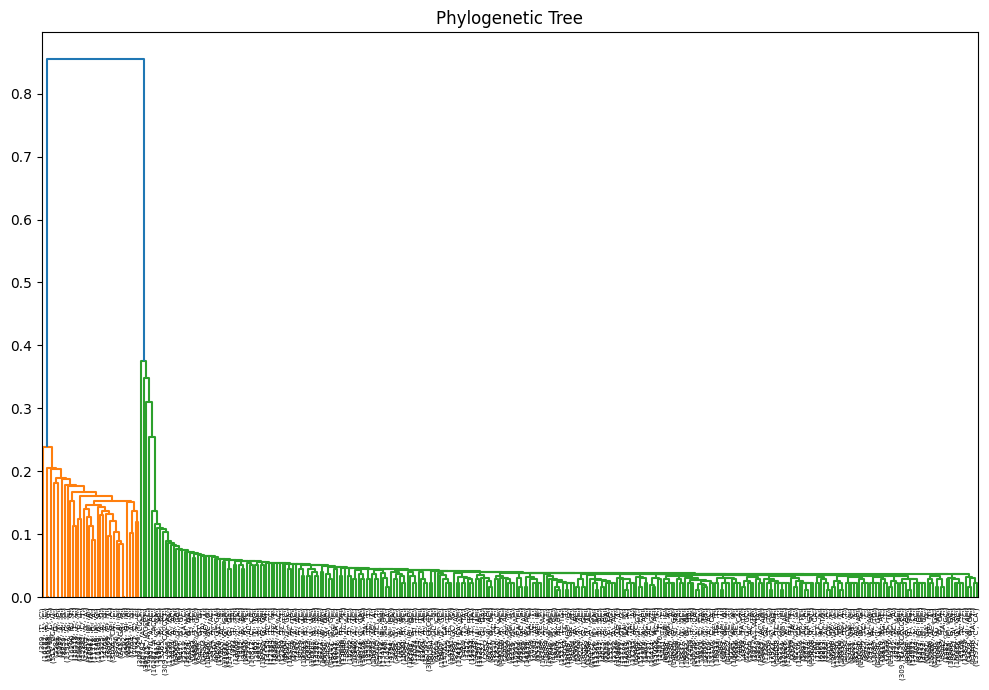

In [36]:
    # Calculate pairwise distances
    distances = pdist(matrix, metric='hamming')
    
    # Create linkage matrix
    linkage_matrix = linkage(distances, method='average')  # UPGMA clustering
    
    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels= var_record, leaf_rotation=90)
    plt.title('Phylogenetic Tree')
    plt.tight_layout()
    plt.show()

In [41]:
# row wise correlation between heteroplasmies
import seaborn as sns

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
         54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
         63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
         72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
         81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
         90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
         99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
        108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
        117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
      

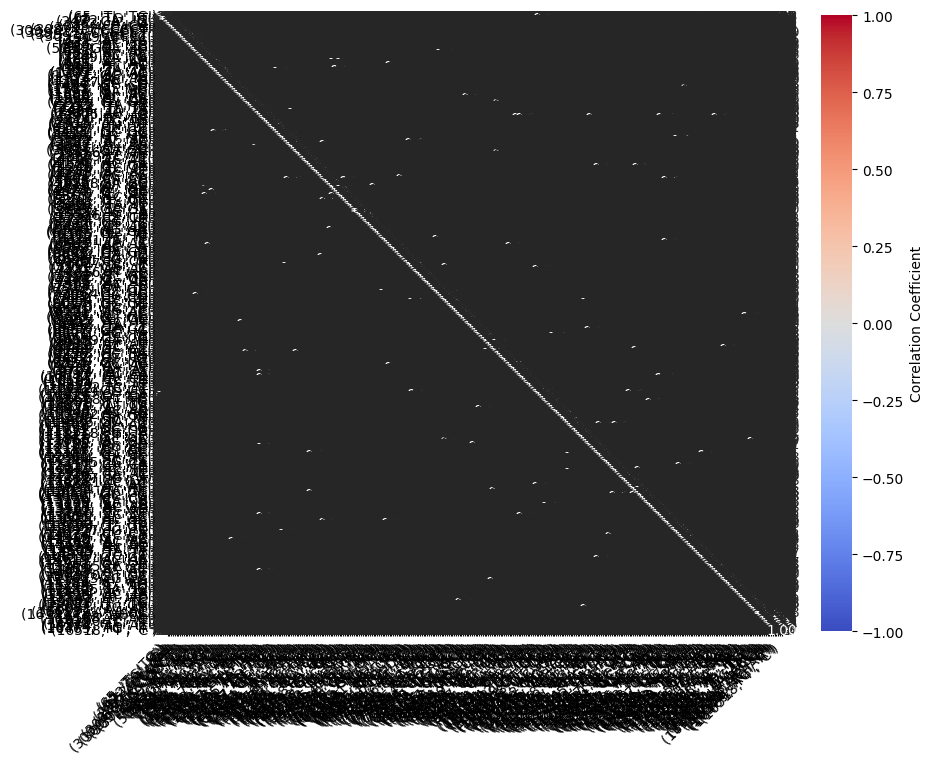

In [42]:
corr_matrix = pd.DataFrame(numpy.corrcoef(df), 
                             index=df.index,
                             columns=df.index)

# Create figure
plt.figure(figsize=[10, 8])

# Create heatmap
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            center=0,
            square=True,
            annot=True,  # Show correlation values
            fmt='.2f',   # Format for correlation values
            cbar_kws={'label': 'Correlation Coefficient'},
            xticklabels=True,
            yticklabels=True)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

In [46]:
threshold = 0.5
high_corr = numpy.where(numpy.triu(numpy.abs(corr_matrix) > threshold, k=1))
for i, j in zip(*high_corr):
    print(f"High correlation ({corr_matrix.iloc[i,j]:.2f}) between:")
    print(f"  {var_record[i]}")
    print(f"  {var_record[j]}\n")

High correlation (0.66) between:
  (65, 'TG', 'T')
  (10421, 'C', 'CA')

High correlation (1.00) between:
  (247, 'GA', 'G')
  (262, 'A', 'G')

High correlation (0.51) between:
  (285, 'C', 'CA')
  (13676, 'A', 'AC')

High correlation (0.51) between:
  (659, 'T', 'TC')
  (1339, 'GC', 'G')

High correlation (0.66) between:
  (659, 'T', 'TC')
  (7927, 'C', 'CG')

High correlation (0.51) between:
  (801, 'A', 'AC')
  (2792, 'A', 'AC')

High correlation (0.57) between:
  (866, 'A', 'AC')
  (4878, 'G', 'GC')

High correlation (0.66) between:
  (866, 'A', 'AC')
  (5217, 'TC', 'T')

High correlation (0.66) between:
  (961, 'TC', 'T')
  (6583, 'AC', 'A')

High correlation (0.51) between:
  (961, 'TC', 'T')
  (10047, 'CA', 'C')

High correlation (0.57) between:
  (992, 'TA', 'T')
  (4978, 'T', 'TA')

High correlation (0.57) between:
  (1277, 'A', 'AC')
  (3428, 'G', 'GC')

High correlation (0.51) between:
  (1339, 'GC', 'G')
  (3674, 'CA', 'C')

High correlation (0.51) between:
  (1339, 'GC', '